In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import folium
import numpy as np
import os
import seaborn as sn
from shapely.geometry import Point
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.simplefilter('ignore')
plt.style.use('ggplot')

In [2]:
# Connect to Oracle
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# MARTINI riverine inputs: data pre-processing

This notebook takes raw data extracted from the national monitoring databases in Norway, Sweden and Denmark and restructures it to a common format for further processing.

For each site, we are interested in the following parameters:

 * Discharge (Q)
 * Inorganic N and P species (NO2, NO3, NH4, TIP)
 * Organic N and P species, split into dissolved and particulate fractions (DON, PON, DOP, POP)
 * Total and dissolved organic carbon (TOC, DOC)
 * Total and dissovled silicate (SiO2 and DSiO2)
 * Suspended sediment (SS)
 
The period of interest for Martini is 2015 to 2017 but, initially, I need a broader time period for building reasonable regression models. I have therefore extracted all available data between 2000 and 2018 as a starting point.
 
## 1. Rivers of interest

André has previously defined 39 distinct rivers of interest (with 42 outlet points in the marine model) - see e-mail from André received 02.10.2018 at 11.02 for details. Outflow points for the Danish rivers have been subsequently modified - see [here](https://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/danish_data.ipynb). This **needs further discussion with Phil and  André**.

Note that I can't find any suitable post-2000 data for station `nmca010` (Sageneelva).

In [3]:
# Read Andre's list of rivers
riv_xlsx = r'../data/martini_river_outlets.xlsx'
riv_df = pd.read_excel(riv_xlsx, sheet_name='rivers')
riv_df

,martini_id,martini_code,station_name,resa_id,external_db_id,lat,lon,country
0,1,smca108,Göta Älv,NaN,43,57.689600,11.897400,Sweden
1,2,smca108,Göta Älv Kungälv,NaN,43,57.794700,11.838600,Sweden
2,3,smca109,Bäveån,NaN,31,58.344500,11.910700,Sweden
3,4,smca110,Örekilsälven,NaN,32,58.437700,11.683200,Sweden
4,5,smca111,Strömsån,NaN,42954,58.939500,11.170000,Sweden
5,6,smca112,Enningdalsälven,NaN,35,58.981800,11.474200,Sweden
6,7,nmca001,Haldenvassdraget,29830.0,001-38541,59.118700,11.369700,Norway
7,8,nmca002,Glomma-Østerelva,29617.0,002-38516,59.181300,10.952700,Norway
8,9,nmca002,Glomma-Vesterelva,29617.0,002-38516,59.184600,10.881900,Norway
9,10,nmca003,Mossevassdraget,30129.0,003-30718,59.439200,10.661000,Norway


In [4]:
# Map
nivapy.spatial.quickmap(riv_df, 
                        lat_col='lat', 
                        lon_col='lon', 
                        popup='martini_code',
                        tiles='openstreetmap')

## 2. Process Norway data

Data for Norway has been extracted from [Vannmiljø](https://vannmiljo.miljodirektoratet.no/) and is supplemented with data from NIVA's RESA2 database below. In Vannmiljø, I have used the following search terms for "parameters":

 * All **næeringsstofforhold**
 
 * All **organisk materiale**
 
 * **Suspendert** and **total tørrstoff**
 
### 2.1. Streamline Vannmiljø dataset

The raw Vannmiljø export includes data for all sites in Norway. The code below filters to just the stations of interest and does some basic co-ordinate conversions, renaming of columns etc. This cell does not need to be re-run unless the MVM export is updated.

In [5]:
# Read Vannmiljø dataset
vm_xlsx = r'../data/raw/vannmiljo/vannmiljo_export_2019-07-01.xlsx'
wc_df = pd.read_excel(vm_xlsx, sheet_name='VannmiljoEksport')

# Filter to stns of interest
vm_stns = riv_df[riv_df['martini_code'].str.startswith('nmca')]['external_db_id'].dropna().unique()
wc_df = wc_df.query('Vannlokalitet_kode in @vm_stns')

# Rename and tidy
wc_df['station_id'] = wc_df['Vannlokalitet_kode'].str.split('-').str[0]
wc_df['utm_zone'] = 33
wc_df['Tid_provetak'] = pd.to_datetime(wc_df['Tid_provetak'], format='%Y-%m-%d %H:%M:%S')
wc_df['Verdi'] = wc_df['Verdi'].astype(str).str.replace(',', '.').astype(float)
wc_df.rename({'Vannlokalitet':'station_name',
              'Parameter_id':'parameter',
              'Tid_provetak':'sample_date',
              'Ovre_dyp':'depth1',
              'Nedre_dyp':'depth2',
              'Operator':'flag',
              'Verdi':'value',
              'Enhet':'unit',
              'UTM33 Ost (X)':'easting',
              'UTM33 Nord (Y)':'northing'},
             inplace=True, axis=1)

# Filter cols
cols = ['station_id', 'station_name', 'easting', 'northing', 'utm_zone',
        'sample_date', 'depth1', 'depth2', 'parameter', 'flag', 
        'value', 'unit']
wc_df = wc_df[cols]
wc_df.reset_index(inplace=True, drop=True)

# Convert UTM to dd
wc_df = nivapy.spatial.utm_to_wgs84_dd(wc_df, 
                                       east='easting', 
                                       north='northing', 
                                       zone='utm_zone')

# Filter cols
cols = ['station_id', 'station_name', 'lon', 'lat', 'sample_date', 
        'depth1', 'depth2', 'parameter', 'flag', 'value', 'unit']
wc_df = wc_df[cols]

# Save as csv for faster processing
vm_csv = r'../data/raw/vannmiljo/vannmiljo_streamlined_2019-07-01.csv'
wc_df.to_csv(vm_csv, index=False, encoding='utf-8')

In [6]:
# Read tidied Vannmiljø data back from csv for speed
vm_csv = r'../data/raw/vannmiljo/vannmiljo_streamlined_2019-07-01.csv'
wc_df = pd.read_csv(vm_csv)
del wc_df['flag']

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date']).dt.date

### 2.2. Supplement with data from RESA2

Checking of the Vannmiljø dataset reveals that at least some of the NIVA data are missing. I will therefore extract all the NIVA data for the RID sites since 2000 and combine it with what is in Vannmiljø. This will produce duplicates for some station-parameter-date combinations, but these can be averaged to create a more complete dataset.

In [7]:
# RESA stations of interest
stn_list = list(riv_df['resa_id'].dropna())

# Pars of interest (TOT-N, NO3, TOC, TOT-P, NH4, PO4, DOC, SPM, TSM, SiO2)
par_list = [4, 5, 6, 24, 49, 285, 879, 1040, 1067, 721]

# Date range
st_dt = '2000-01-01'
end_dt = '2018-12-31'

# Get data from RESA
res_df, dup_df = nivapy.da.select_resa_water_chemistry(stn_list,
                                                       par_list,
                                                       st_dt,
                                                       end_dt,
                                                       eng,
                                                       drop_dups=True,
                                                       lod_flags=False)

# Datetimes to dates
res_df['sample_date'] = pd.to_datetime(res_df['sample_date']).dt.date
del res_df['station_code'], res_df['station_name']

# Melt
res_df = res_df.melt(id_vars=['station_id', 'sample_date', 'depth1', 'depth2'],
                     var_name='par_unit')

# Split par and unit
res_df['parameter'], res_df['unit'] = res_df['par_unit'].str.split('_', 1).str
del res_df['par_unit']
res_df.dropna(subset=['value'], inplace=True)

# Join vassnrs from Andre's data
res_df = pd.merge(res_df, riv_df[['resa_id', 'martini_code']],
                  how='left',
                  left_on='station_id', 
                  right_on='resa_id')

# Extract vassnr
res_df['station_id'] = res_df['martini_code'].str[-3:].astype(int)

# Join station metadata from Vannmiljø
chem_met_df = wc_df[['station_id', 'station_name', 'lon', 'lat']].copy().drop_duplicates()
res_df = pd.merge(res_df, chem_met_df,
                  how='left', on='station_id')

# Gets cols of interest
res_df = res_df[['station_id', 'station_name', 'lon', 'lat', 'sample_date', 
                 'depth1', 'depth2', 'parameter', 'value', 'unit']]

res_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_name,lon,lat,sample_date,depth1,depth2,parameter,value,unit
0,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-01-08,0,0,DOC,2.8,mg/L C
1,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-02-05,0,0,DOC,2.4,mg/L C
2,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-02-05,0,0,DOC,2.4,mg/L C
3,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-03-05,0,0,DOC,2.3,mg/L C
4,12,Drammenselva ved Mjøndalen bru,10.009034,59.753432,2013-04-04,0,0,DOC,2.7,mg/L C


In [8]:
# Combine with RESA data
wc_df = pd.concat([wc_df, res_df], axis=0, sort=False)
wc_df.head()

,station_id,station_name,lon,lat,sample_date,depth1,depth2,parameter,value,unit
0,9,ÅROS (ÅRO-206),10.498553,59.711477,2007-11-14,1.0,1.0,P-PO4-F,5.7,µg/l P
1,9,ÅROS (ÅRO-206),10.498553,59.711477,2005-08-01,1.0,1.0,TOC,8.8,mg/l C
2,9,ÅROS (ÅRO-206),10.498553,59.711477,2000-06-20,1.0,1.0,N-TOT,880.0,µg/l N
3,9,ÅROS (ÅRO-206),10.498553,59.711477,2005-01-03,1.0,1.0,TOC,6.2,mg/l C
4,9,ÅROS (ÅRO-206),10.498553,59.711477,2005-05-02,1.0,1.0,N-TOT,1100.0,µg/l N


### 2.3. Tidy/aggregate Vannmiljø data

The Vannmiljø and NIVA databases use different parameter names and units, and there are multiple values for the same station-date-parameter combinations. The code below performs the following standardisations and then **averages duplicates** (including averaging over multiple depths in a few cases):

    DOC       => Unchanged
    N-NH4     => Unchanged
    N-NO3     => Unchanged
    N-SNOX    => Unchanged
    N-TOT     => Unchanged
    NH4-N     => N-NH4. RESA2 to Vannmiljø
    NO3-N     => N-NO3. RESA2 to Vannmiljø
    P-ORTO    => TRP. Total reactive P
    P-ORTO-F  => SRP. Soluble reactive P 
    P-PO4     => TIP. Total inorg. P
    P-PO4-F   => DIP. Dissolved inorg. P
    P-TOT     => Unchanged
    P-TOT-F   => TDP. Total dissovled P
    PO4-P     => TIP. Rename RESA parameter
    POC       => Unchanged
    PON       => Unchanged
    SI-SIO2   => DSIO2. Dissolved reactive Si
    SIO2      => Unchanged. Total Si
    SiO2      => SIO2. RESA2 to Vannmiljø
    SPM       => STS. RESA2 to Vannmiljø
    STS       => Unchanged
    TOC       => Unchanged
    TOTN      => N-TOT. RESA2 to Vannmiljø
    TOTP      => P-TOT. RESA2 to Vannmiljø

See [here](https://vannmiljokoder.miljodirektoratet.no/Parameter.aspx?p=FKE#nodesc) for details of Vannmiljø parameter codes and lab methods.

**Note:** The Vannmiljø method names are a bit strange. A typical water sample will contain:

 1. Short-chain, inorganic phosphate molecules, usually referred to as “orthophosphate” or “monophosphate” and assumed to be readily bioavailable/"reactive"

 2. Longer-chain, inorganic phosphate molecules (“polyphosphates” or “condensed phosphates”) which are less bioavailable/"reactive" than (1), but more bioavailable than (3)

 3. Organic phosphates, which are not immediately bioavailable

(All the following analyses can be applied to filtered (-F) or unfiltered samples).
 
P-PO4(-F) and P-ORT(-F) are most commonly used as alternative names for the same thing: an undigested analysis for P-PO4(-F) or P-ORT(-F) will both measure the “reactive” component (1). However, Vannmiljø does not follow this convention – see below.

You can also digest *all* the P in the sample using persulphate and measure P-TOT(-F), which gives the sum of (1), (2) and (3). The organic fraction is then commonly estimated as the difference between these two (i.e. P-TOT minus P-PO4 or P-ORT). However, this classifies (2) as part of the organic fraction, which is incorrect.

Inorganic P (also called acid-hydrolysable P) can be estimated more accurately by adding a small amount of sulphuric acid to the undigested sample. This breaks down the long-chain inorganic phosphates (2), without digesting (much of) the organic material (3). The undigested analysis then measures (1) + (2), which is the true inorganic content (i.e. reactive + condensed). The organic fraction is then estimated as P-TOT minus this inorganic (or "acid-hydrolysable") fraction.

For completeness, it is also possible (but uncommon) to explicitly quantify the condensed/polyphosphates, (2), as inorganic minus P-PO4 or P-ORT.

Unusually (I think), Vannmiljø uses P-ORT(-F) to refer to "reactive" P, (1), and P-PO4(-F) to refer to inorganic/acid-hydrolysable P, (2). This is confusing. In Vannmiljø terminology, `P-PO4(-F)` is "inorganic P", which should always be higher than `P-ORT(-F)` ("reactive" P), but lower than `P-TOT(-F)`. 

In [9]:
# Copy raw data
wc_df2 = wc_df.copy()

# Rename pars to match Vannmiljø
par_dict = {'NH4-N'   :'N-NH4',
            'NO3-N'   :'N-NO3',
            'P-ORTO'  :'TRP',
            'P-ORTO-F':'SRP',
            'P-PO4'   :'TIP',
            'P-PO4-F' :'DIP',
            'P-TOT-F' :'TDP',
            'PO4-P'   :'TIP',
            'SI-SIO2' :'DSIO2',
            'SiO2'    :'SIO2',
            'SPM'     :'STS',
            'TOTN'    :'N-TOT',
            'TOTP'    :'P-TOT',
           }    
wc_df2['parameter'].replace(par_dict, inplace=True)

# Convert RESA SiO2 => Si in ug/l
si_df = pd.DataFrame({'unit':  ['µg/l SiO2', 'mg SiO2/l'],
                      'factor':[28.09/60.09, (1000*28.09)/60.09]})
wc_df2 = pd.merge(wc_df2, si_df, how='left', on='unit')
wc_df2['factor'].fillna(1, inplace=True)
wc_df2['value'] = wc_df2['value'] * wc_df2['factor']
del wc_df2['factor']

# Rename units
unit_dict = {'µg/l N':   'µg/l',
             'µg/l P':   'µg/l',
             'µg/l C':   'µg/l',
             'mg/l C':   'mg/l',
             'mg/L C':   'mg/l', 
             'mg C/l':   'mg/l',
             'µg/l Si':  'µg/l',
             'µg/l SiO2':'µg/l',
             'mg SiO2/l':'µg/l',
            }
wc_df2['unit'].replace(unit_dict, inplace=True)

# There are obvious unit errors in the Vannmiljø data for N-Tot at vassnr 008:
# Some values are a factor of 1000 too small
condition = (wc_df2['station_id']==8) & (wc_df2['parameter']=='N-TOT') & (wc_df2['value']<3)
wc_df2['value'][condition] = 1000*wc_df2['value'][condition]

# Merge cols
wc_df2['par_unit'] = wc_df2['parameter'] + '_' + wc_df2['unit']
del wc_df2['depth1'], wc_df2['depth2'], wc_df2['parameter'], wc_df2['unit']

# Average duplicates
idx_cols = ['station_id', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
wc_df2 = wc_df2.groupby(idx_cols).mean().reset_index()

# Save to CSV
csv_path = r'../data/tidy/martini_norway_chem_tidy.csv'
wc_df2.to_csv(csv_path, index=False, encoding='utf-8')

wc_df2.head()

,station_id,station_name,lon,lat,sample_date,par_unit,value
0,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-NH4_µg/l,21.000000
1,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-NO3_µg/l,574.000000
2,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-TOT_µg/l,936.000000
3,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,SIO2_µg/l,40.068469
4,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,STS_mg/l,2.140000


### 2.4. Plot raw data

In [10]:
# Plots of raw data
for vass in wc_df2['station_id'].unique():
    # Get stn data
    df = wc_df2.query('station_id == @vass')
    
    # Restructure
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['station_id'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Plot
    df.plot(subplots=True, 
            layout=(3,5), 
            figsize=(15,6), 
            marker='o',
            title=list(df.columns),
            legend=False)    
    plt.tight_layout()
    
    # Save png
    png_path = r'../plots/raw_data/vassnr_%03d.png' % vass
    plt.savefig(png_path, dpi=300)
    plt.close() 

Raw data for vassdragområde 25.


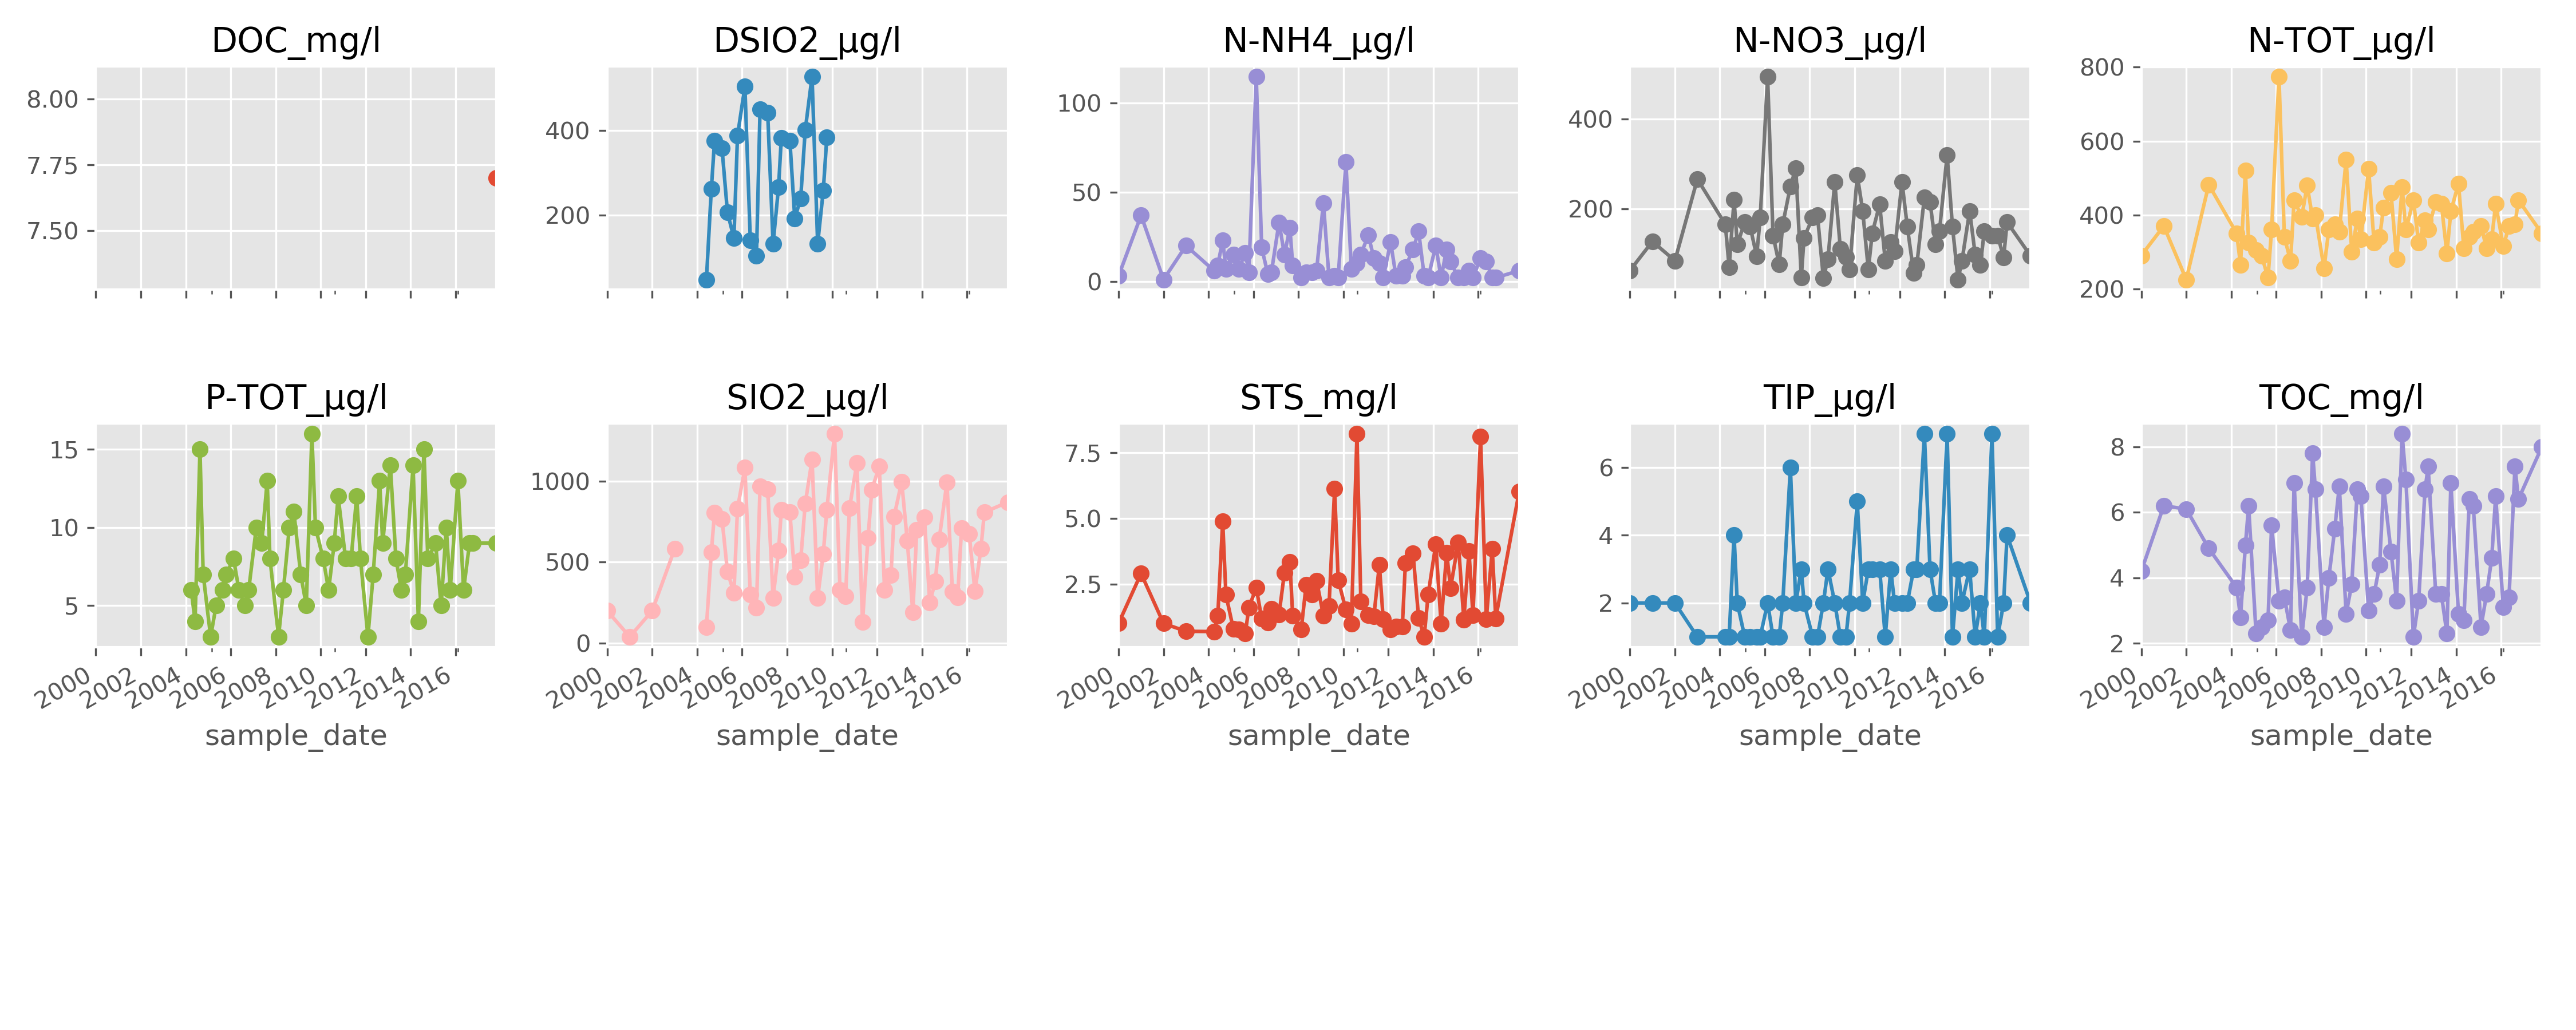

In [11]:
# Show example image
print ('Raw data for vassdragområde %s.' % vass)
Image(png_path)

## 3. Process Sweden data

##### Water chemistry

Water chemistry data for Sweden are available from the [MVM database](http://miljodata.slu.se/mvm). After a bit of searching, it looks as though the following stations will be most appropriate for the river outlets in Andre's file:

 * Göta älv, Alelyckan
 * Bäveån Uddevalla
 * Örekilsälven Munkedal
 * Enningdalsälv N.Bullaren
 * Strömsån, utflöde

[This link](http://miljodata.slu.se/mvm/Query?sites=31,32,35,43,42954&products=6&parameters=Q,C_org,DOC,NH4_N,NO2_NO3_N,NO2_N,NO3_N,N_org,P,Part-P,PO4_P,PO4_P_F,Si,Si_F,Susp,TOC,Tot_N,Tot_N_F,Tot_N_ps,Tot_N_summa,Tot_N_TNb,Tot_P,Tot_P_F&startdate=2000-01-01&enddate=2019-01-01) should make it possible to repeate the manual export of data for these locations in the future. Alternatively, I have recently created a Python module called [MVM Python](https://github.com/NIVANorge/mvm_python), which is designed to make it easier to automatically download MVM data via their web API.

**Note:** The Göta älv splits into two parts above Göteborg and flows into different cells in the marine model. I can't find good water chemistry data upstream of this bifurcation; the best data come from lower down the southern branch of the river at Alelyckan. **I will assume these concentrations are represenative of both branches of the river**.  

##### Discharge

Modelled, bias-corrected discharge data for Sweden is available via E-HYPE [here](https://vattenwebb.smhi.se/modelarea/). This makes it easy to click on any location in Sweden and download daily discharge time series (from 1990 to 2017) comparable to that supplied for Norway by NVE. I have downloaded discharge datasets for the five chemistry monitoring locations listed above. Note that for Göta älv I've downloaded two flow time series: one close to the chemistry monitoring station at Alelyckan, which will be used in the regressions, and another on the northern outflow branch, which may be useful for the marine modelling.

### 3.1. Streamline MVM dataset

The code below does some basic tidying and saves the results to CSV. This cell does not need to be re-run unless the MVM export is updated.

In [12]:
# Read Vannmiljø dataset
mvm_xlsx = r'../data/raw/mvm/mvm_export_2019-07-01.xlsx'
wc_df = pd.read_excel(mvm_xlsx, sheet_name='Mätvärden Vattenkemi')

# Rename and tidy
wc_df['Provdatum'] = pd.to_datetime(wc_df['Provdatum'], format='%Y-%m-%d')
wc_df['Värde/Koncentration'] = wc_df['Värde/Koncentration'].str.replace('<', '')
wc_df['Värde/Koncentration'] = wc_df['Värde/Koncentration'].astype(str).str.replace(',', '.').astype(float)
wc_df.rename({'Stationsnamn':'station_name',
              'MD-MVM Id':'station_id',
              'Parameter':'parameter',
              'Provdatum':'sample_date',
              'Min provdjup (m)':'depth1',
              'Max provdjup (m)':'depth2',
              'Värde/Koncentration':'value',
              'Enhet':'unit',
              'Stationskoordinat N/X':'northing',
              'Stationskoordinat E/Y':'easting'},
             inplace=True, axis=1)

# Filter cols
cols = ['station_id', 'station_name', 'easting', 'northing',
        'sample_date', 'depth1', 'depth2', 'parameter',
        'value', 'unit']
wc_df = wc_df[cols]
wc_df.reset_index(inplace=True, drop=True)

# Convert from spatial co-ords from SWEREF-99-TM (= EPSG 3006) to dd
geometry = [Point(xy) for xy in zip(wc_df.easting, wc_df.northing)]
crs = {'init': 'epsg:3006'}
gdf = gpd.GeoDataFrame(wc_df, crs=crs, geometry=geometry)
gdf = gdf.to_crs({'init': 'epsg:4326'})
gdf['lat'] = gdf.geometry.y
gdf['lon'] = gdf.geometry.x
del gdf['geometry'], gdf['easting'], gdf['northing']
wc_df = pd.DataFrame(gdf)

# Filter cols
cols = ['station_id', 'station_name', 'lon', 'lat', 'sample_date', 
        'depth1', 'depth2', 'parameter', 'value', 'unit']
wc_df = wc_df[cols]

# Save as csv for faster processing
mvm_csv = r'../data/raw/mvm/mvm_streamlined_2019-07-01.csv'
wc_df.to_csv(mvm_csv, index=False, encoding='utf-8')

In [13]:
# Read tidied MVM data back from csv for speed
mvm_csv = r'../data/raw/mvm/mvm_streamlined_2019-07-01.csv'
wc_df = pd.read_csv(mvm_csv)

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date']).dt.date

wc_df.head()

,station_id,station_name,lon,lat,sample_date,depth1,depth2,parameter,value,unit
0,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",NH4-N,36.00,µg/l
1,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",NO2+NO3-N,430.00,µg/l
2,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",PO4-P,21.00,µg/l
3,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",Si,3.51,mg/l
4,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,"0,50","0,50",TOC,9.30,mg/l


### 3.2. Tidy/aggregate MVM data

The following aggregations/simplifications have been made to the MVM data (see [here](http://miljodata.slu.se/mvm/DataContents/Properties) for an explanation of parameter names):

    NH4-N       => N-NH4. MVM to Vannmiljø
    NO2+NO3-N   => N-SNOX. MVM to Vannmiljø
    NO2-N       => N-NO2
    Org-N       => N-ORG. MVM to Vannmiljø
    PO4-P       => TIP. Total inorg. P
    Si          => SIO2. MVM to Vannmiljø
    TOC         => Unchanged
    Tot-N_TNb   => N-TOT. MVM has several methods for total N, but I won't distinguish them here
    Tot-N_ps    => N-TOT. MVM has several methods for total N, but I won't distinguish them here
    Tot-N_summa => N-TOT. MVM has several methods for total N, but I won't distinguish them here
    Tot-P       => P-TOT

In [14]:
# Copy raw data
wc_df2 = wc_df.copy()

# Rename parameters
par_dict = {'NH4-N'       :'N-NH4',
            'NO2+NO3-N'   :'N-SNOX',
            'NO2-N'       :'N-NO2',
            'Org-N'       :'N-ORG',
            'PO4-P'       :'TIP',
            'Si'          :'SIO2',
            'Tot-N_TNb'   :'N-TOT',
            'Tot-N_ps'    :'N-TOT',
            'Tot-N_summa' :'N-TOT',
            'Tot-P'       :'P-TOT',
           }
wc_df2['parameter'].replace(par_dict, inplace=True)

# Convert Si from mg/l to ug/l
condition = wc_df2['parameter'] == 'SIO2'
wc_df2['value'][condition] = 1000 * wc_df2['value'][condition]
wc_df2['unit'][condition] = 'µg/l'

# Rename units
unit_dict = {'µg/l N':'µg/l'}
wc_df2['unit'].replace(unit_dict, inplace=True)

# Merge cols
wc_df2['par_unit'] = wc_df2['parameter'] + '_' + wc_df2['unit']

# Average duplicates
idx_cols = ['station_id', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
wc_df2 = wc_df2.groupby(idx_cols).mean().reset_index()

# Save to CSV
csv_path = r'../data/tidy/martini_sweden_chem_tidy.csv'
wc_df2.to_csv(csv_path, index=False, encoding='utf-8')

wc_df2.head()

,station_id,station_name,lon,lat,sample_date,par_unit,value
0,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,N-NH4_µg/l,36.0
1,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,N-SNOX_µg/l,430.0
2,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,N-TOT_µg/l,917.0
3,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,P-TOT_µg/l,68.0
4,31,Bäveån Uddevalla,11.939269,58.347117,2000-01-14,SIO2_µg/l,3510.0


### 3.3. Plot raw data

In [15]:
# Plots of raw data
for mvm_id in wc_df2['station_id'].unique():
    # Get stn data
    df = wc_df2.query('station_id == @mvm_id')
    
    # Restructure
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['station_id'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Plot
    df.plot(subplots=True, 
            layout=(3,5), 
            figsize=(15,6), 
            marker='o',
            title=list(df.columns),
            legend=False)    
    plt.tight_layout()
    
    # Save png
    png_path = r'../plots/raw_data/mvm_id_%05d.png' % mvm_id
    plt.savefig(png_path, dpi=300)
    plt.close()

Raw data for MVM ID 42954.


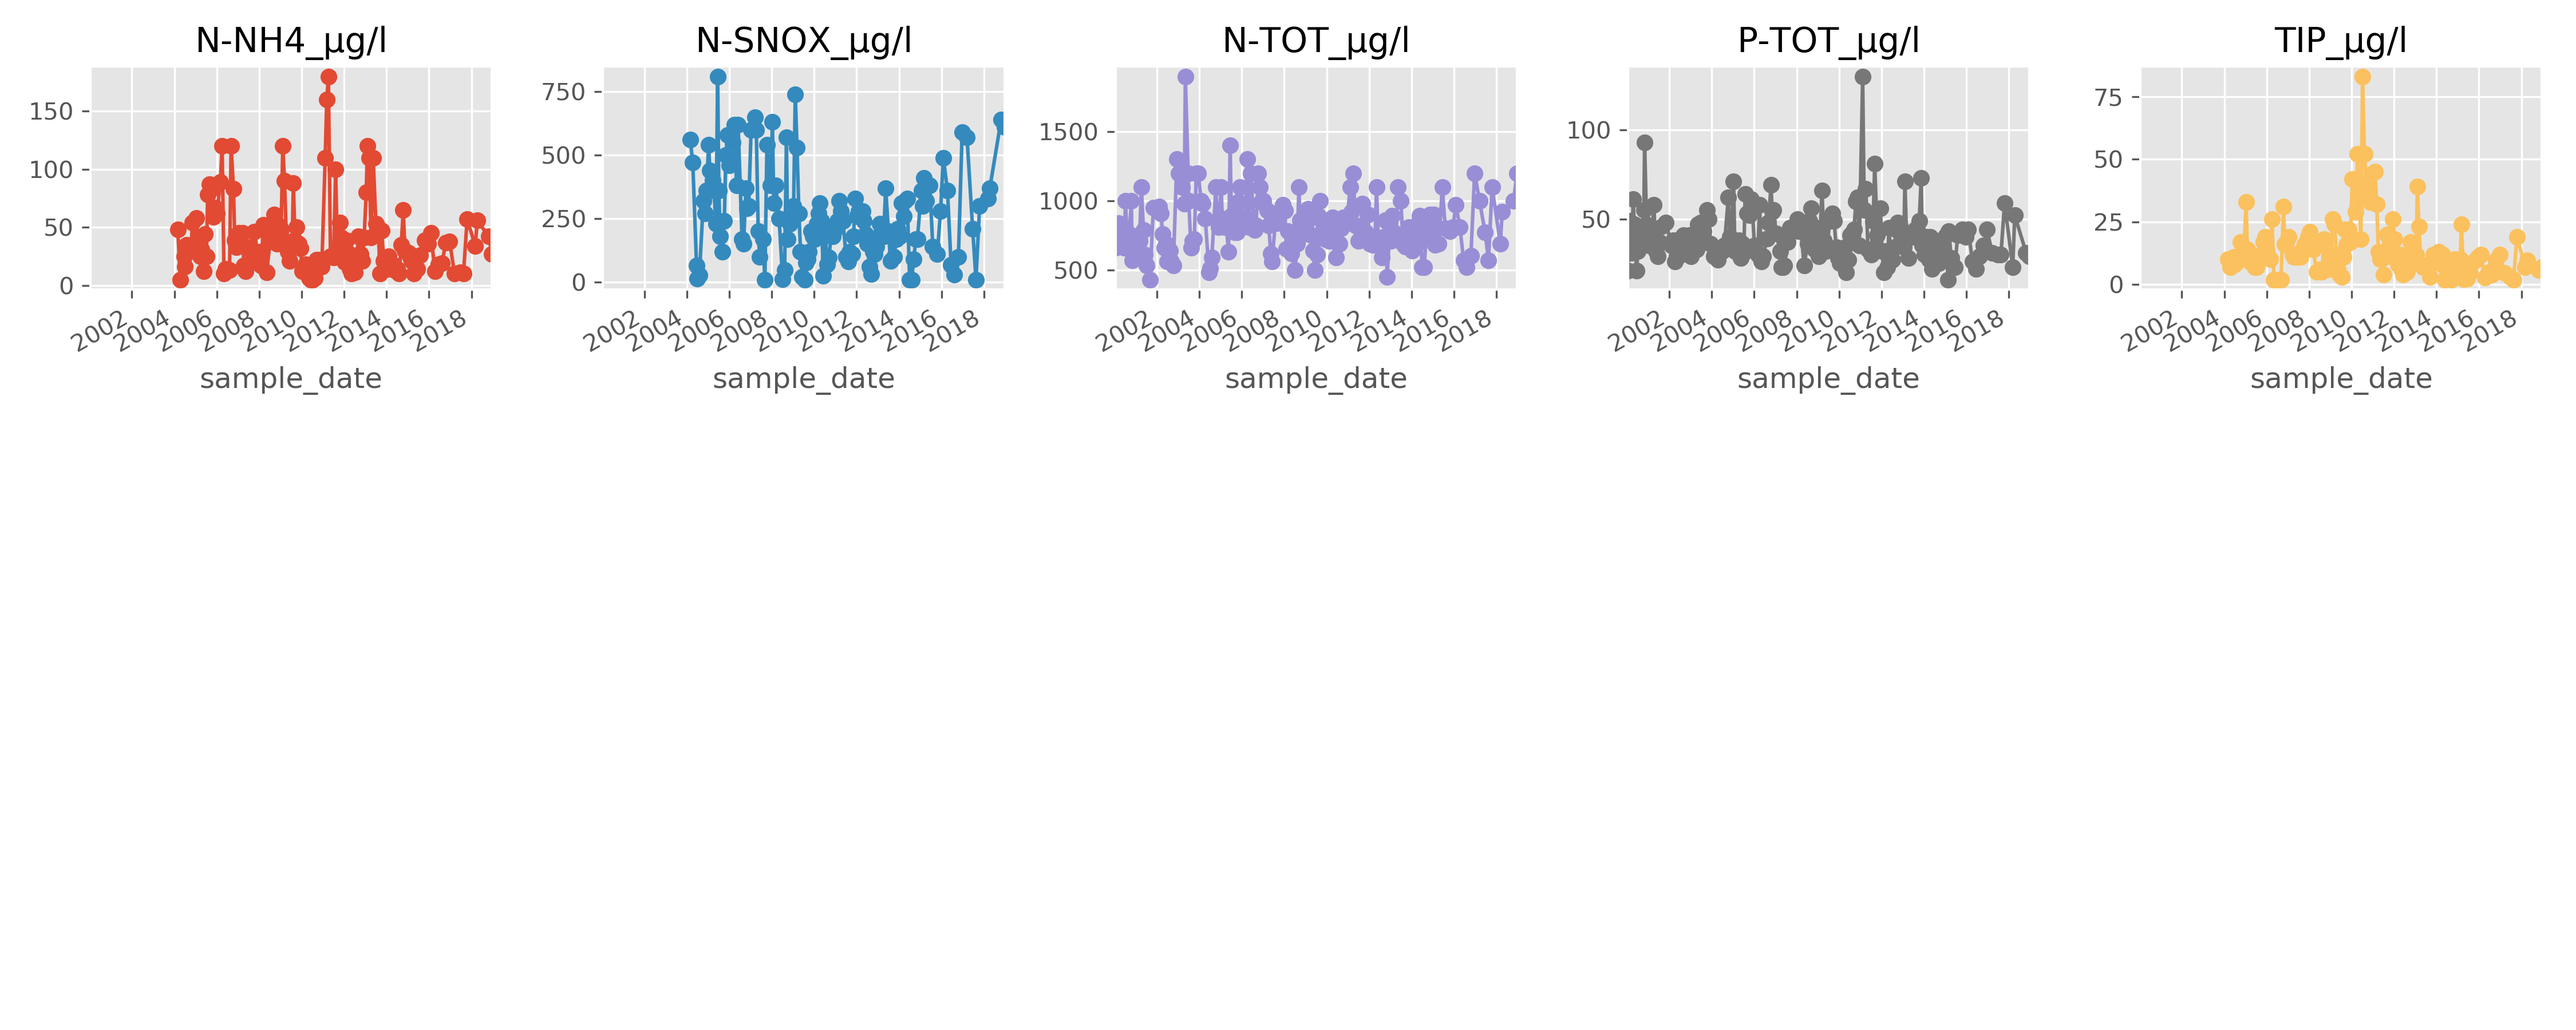

In [16]:
# Show example image
print ('Raw data for MVM ID %s.' % mvm_id)
Image(png_path)

## 4. Process Denmark data

Denmark has recently made the [ODA database](https://odaforalle.au.dk/login.aspx) publicly available. I cannot find data corresponding to André's outflow points, but I have downloaded water chemistry and discharge data for 19 relevant stations - see [this notebook](https://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/danish_data.ipynb) for details.

### 4.1. Streamline ODA dataset

The code below does some basic tidying and saves the results to CSV. This cell does not need to be re-run unless the MVM export is updated.

In [17]:
# Read ODA dataset
oda_xlsx = r'../data/raw/oda/oda_export_2019-07-01.xlsx'
wc_df = pd.read_excel(oda_xlsx, sheet_name='Hent data')

# Rename and tidy
wc_df['Startdato'] = pd.to_datetime(wc_df['Startdato'], format='%Y%m%d')
wc_df.rename({'ObservationsStedNavn':'station_name',
              'ObservationsStedNr':'station_id',
              'Parameter':'parameter',
              'Prøvefraktion':'fraction',
              'Startdato':'sample_date',
              'Resultat':'value',
              'Enhed':'unit',
              'Yutm_Euref89_Zone32':'northing',
              'Xutm_Euref89_Zone32':'easting'},
             inplace=True, axis=1)

# Filter cols
cols = ['station_id', 'station_name', 'easting', 'northing',
        'sample_date', 'parameter', 'fraction', 'value', 'unit']
wc_df = wc_df[cols]
wc_df.reset_index(inplace=True, drop=True)

# Convert from spatial co-ords from ETRS89 Zone32 (= EPSG 25832) to dd
geometry = [Point(xy) for xy in zip(wc_df.easting, wc_df.northing)]
crs = {'init': 'epsg:25832'}
gdf = gpd.GeoDataFrame(wc_df, crs=crs, geometry=geometry)
gdf = gdf.to_crs({'init': 'epsg:4326'})
gdf['lat'] = gdf.geometry.y
gdf['lon'] = gdf.geometry.x
del gdf['geometry'], gdf['easting'], gdf['northing']
wc_df = pd.DataFrame(gdf)

# Filter cols
cols = ['station_id', 'station_name', 'lon', 'lat',
        'sample_date', 'parameter', 'fraction', 'value', 'unit']
wc_df = wc_df[cols]

# Save as csv for faster processing
oda_csv = r'../data/raw/oda/oda_streamlined_2019-07-01.csv'
wc_df.to_csv(oda_csv, index=False, encoding='utf-8')

In [18]:
# Read tidied MVM data back from csv for speed
oda_csv = r'../data/raw/oda/oda_streamlined_2019-07-01.csv'
wc_df = pd.read_csv(oda_csv)

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date']).dt.date

wc_df.head()

,station_id,station_name,lon,lat,sample_date,parameter,fraction,value,unit
0,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,"Phosphor, total-P",Total,0.095712,mg/l
1,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,"Nitrogen,total N",Total,4.582832,mg/l
2,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,Suspenderede stoffer,Total,10.000000,mg/l
3,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,Ammoniak+ammonium-N,Opløst - filtrat fra filtrering,0.150000,mg/l
4,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,Ortho-phosphat-P,Opløst - filtrat fra filtrering,0.027000,mg/l


### 4.2. Tidy/aggregate ODA data

The following aggregations/simplifications have been made to the ODA data:

    ('Ammoniak+ammonium-N', 'Opløst - filtrat fra filtrering') => N-NH4. ODA to Vannmiljø
    ('Ammoniak+ammonium-N', 'Total')                           => N-NH4. ODA to Vannmiljø   
    ('DOC', 'Opløst - filtrat fra filtrering')                 => DOC. ODA to Vannmiljø
    ('Glødetab,susp.stof', 'Total')                            => Removed from dataset (loss on ignition)
    ('Nitrit+nitrat-N', 'Opløst - filtrat fra filtrering')     => N-SNOX. ODA to Vannmiljø
    ('Nitrogen,total N', 'Ej oplyst')                          => N-TOT. ODA to Vannmiljø
    ('Nitrogen,total N', 'Total')                              => N-TOT. ODA to Vannmiljø
    ('Ortho-phosphat-P', 'Opløst - filtrat fra filtrering')    => SRP. Soluble reactive P
    ('Phosphor, total-P', 'Ej oplyst')                         => P-TOT. ODA to Vannmiljø
    ('Phosphor, total-P', 'Opløst - filtrat fra filtrering')   => TDP. Total dissovled P
    ('Phosphor, total-P', 'Total')                             => P-TOT. ODA to Vannmiljø
    ('Suspenderede stoffer', 'Total')                          => STS. ODA to Vannmiljø

In [19]:
def reclassify_oda_pars(row):
    """ Reclassify parameter/sample fraction names in ODA to soemthing simpler.
    """    
    reclass_dict = {('Ammoniak+ammonium-N', 'Opløst - filtrat fra filtrering'):'N-NH4',
                    ('Ammoniak+ammonium-N', 'Total')                          :'N-NH4',
                    ('DOC', 'Opløst - filtrat fra filtrering')                :'DOC',
                    ('Nitrit+nitrat-N', 'Opløst - filtrat fra filtrering')    :'N-SNOX',
                    ('Nitrogen,total N', 'Ej oplyst')                         :'N-TOT',
                    ('Nitrogen,total N', 'Total')                             :'N-TOT',
                    ('Ortho-phosphat-P', 'Opløst - filtrat fra filtrering')   :'SRP',
                    ('Phosphor, total-P', 'Ej oplyst')                        :'P-TOT',
                    ('Phosphor, total-P', 'Opløst - filtrat fra filtrering')  :'TDP',
                    ('Phosphor, total-P', 'Total')                            :'P-TOT',
                    ('Suspenderede stoffer', 'Total')                         :'STS',
                   }
    
    par, frac = row['parameter'], row['fraction']

    return reclass_dict[(par, frac)]

In [20]:
# Copy raw data
wc_df2 = wc_df.copy()

# Remove loss on ignition
wc_df2 = wc_df2.query('parameter not in ("Glødetab,susp.stof")')

# Rename parameters
wc_df2['parameter'] = wc_df2.apply(reclassify_oda_pars, axis=1)

# Convert all units except STS and DOC from mg/l to ug/l
condition = (wc_df2['parameter'] != 'STS') & (wc_df2['parameter'] != 'DOC')
wc_df2['value'][condition] = 1000 * wc_df2['value'][condition]
wc_df2['unit'][condition] = 'µg/l'

# Merge cols
wc_df2['par_unit'] = wc_df2['parameter'] + '_' + wc_df2['unit']

# Average duplicates
idx_cols = ['station_id', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
wc_df2 = wc_df2.groupby(idx_cols).mean().reset_index()

# Save to CSV
csv_path = r'../data/tidy/martini_denmark_chem_tidy.csv'
wc_df2.to_csv(csv_path, index=False, encoding='utf-8')

wc_df2.head()

,station_id,station_name,lon,lat,sample_date,par_unit,value
0,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,N-NH4_µg/l,150.000000
1,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,N-SNOX_µg/l,4100.000000
2,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,N-TOT_µg/l,4582.832200
3,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,P-TOT_µg/l,95.711844
4,1000315,"Klostergrøften, Klostergrøften.",9.72798,57.374123,2016-12-12,SRP_µg/l,27.000000


### 4.3. Plot raw data

In [21]:
# Plots of raw data
for oda_id in wc_df2['station_id'].unique():
    # Get stn data
    df = wc_df2.query('station_id == @oda_id')
    
    # Restructure
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['station_id'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Plot
    df.plot(subplots=True, 
            layout=(3,5), 
            figsize=(15,6), 
            marker='o',
            title=list(df.columns),
            legend=False)    
    plt.tight_layout()
    
    # Save png
    png_path = r'../plots/raw_data/oda_id_%s.png' % oda_id
    plt.savefig(png_path, dpi=300)
    plt.close()

Raw data for ODA ID 21006515.


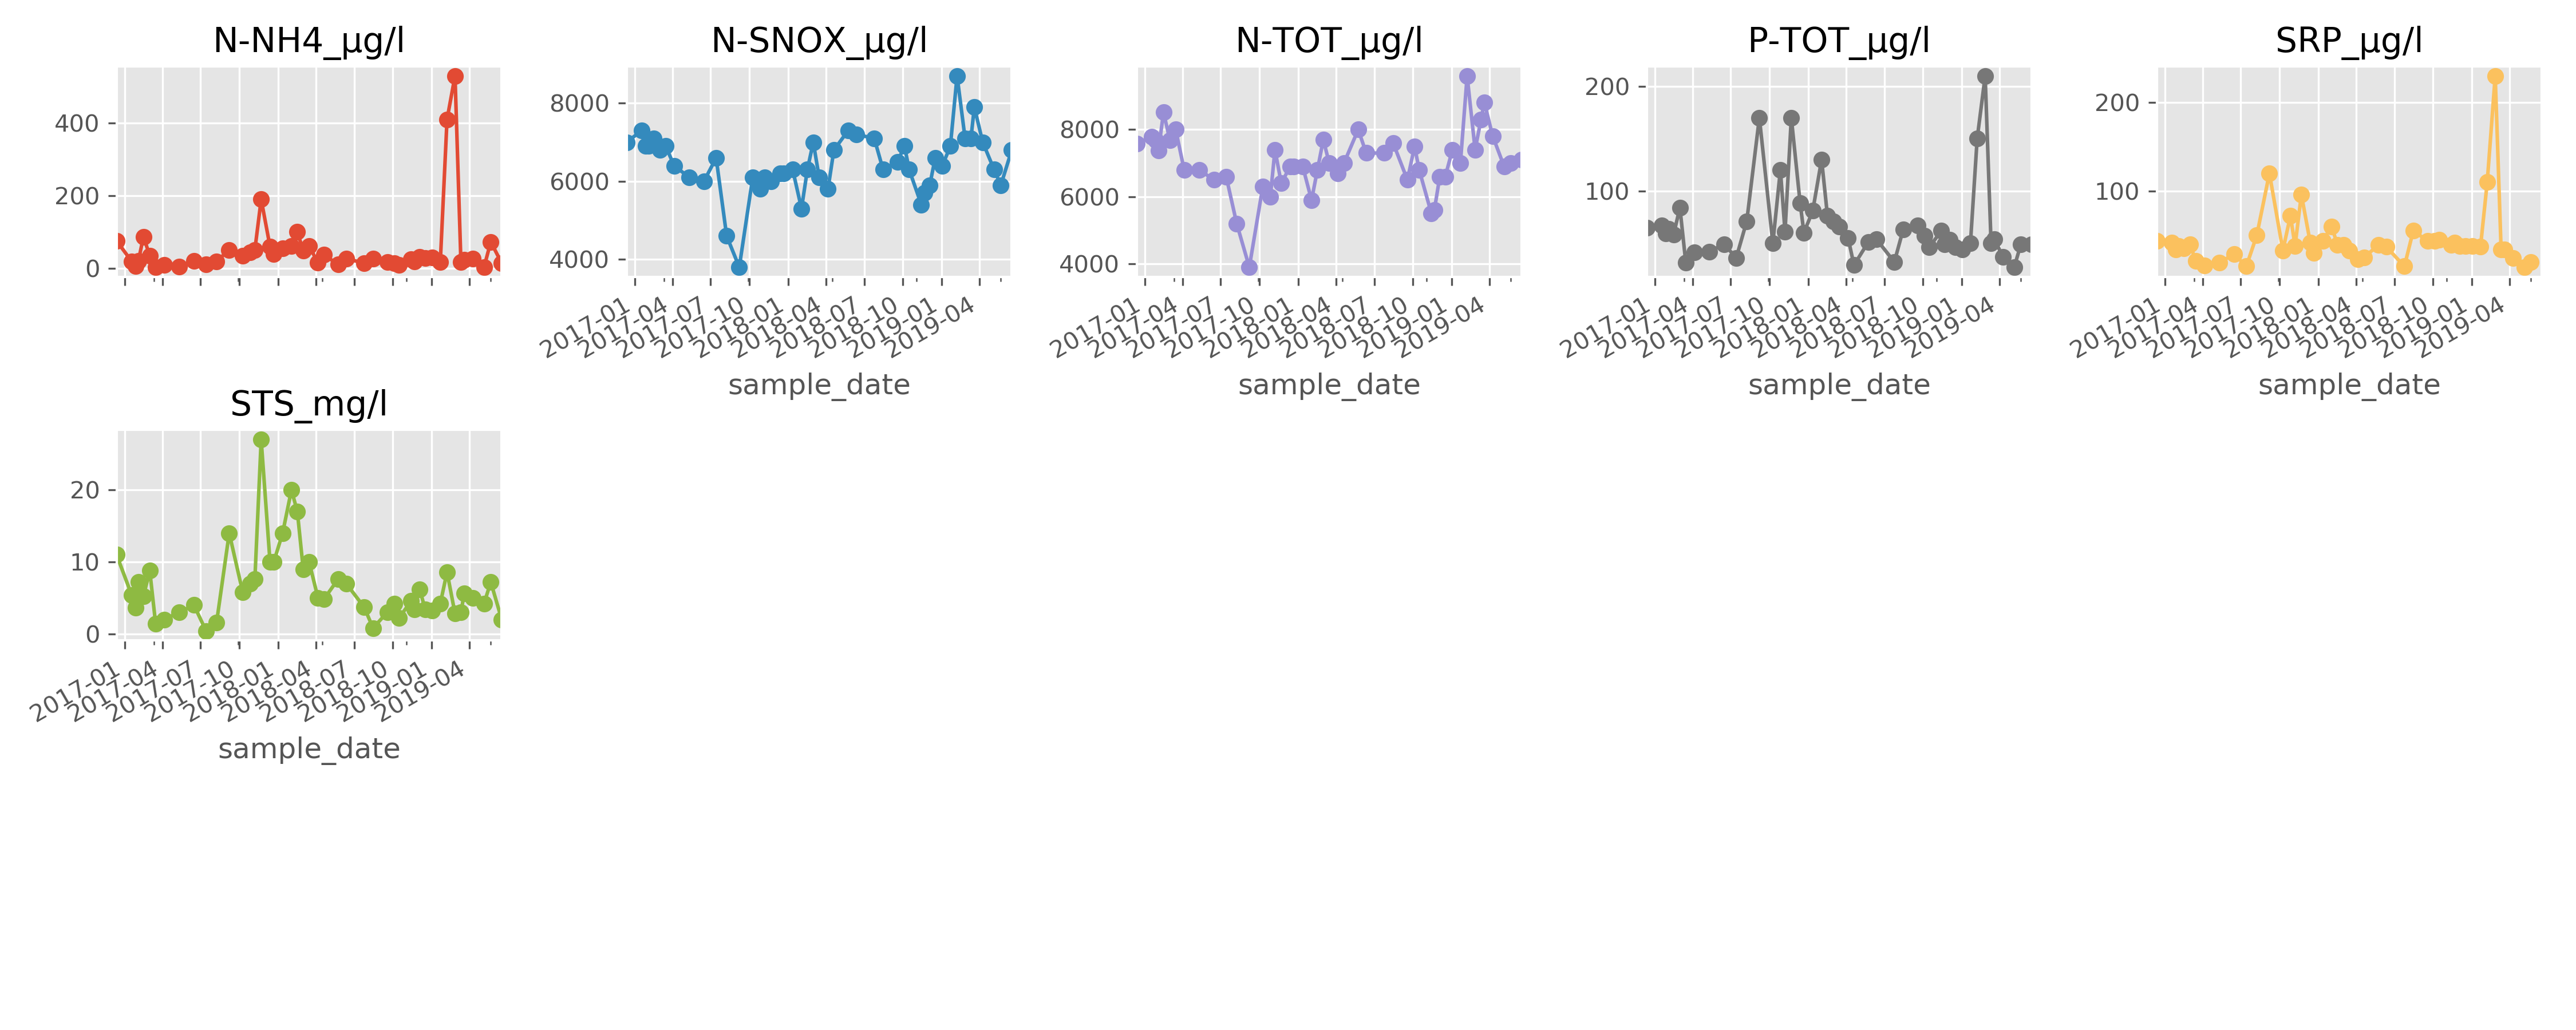

In [22]:
# Show example image
print ('Raw data for ODA ID %s.' % oda_id)
Image(png_path)

## 5. Discharge data

Discharge data for Norway is available from the RESA database (provided by NVE for the RID project). For Sweden, I ahve downloaded E-HYPE data from Vattenwebb, and for Denmark discharge  is available from ODA. The code in this section creates a single file containing daily discharge data for all rivers.

### 5.1. Norway discharge

In [23]:
# Read norway chem
csv_path = r'../data/tidy/martini_norway_chem_tidy.csv'
nor_chem = pd.read_csv(csv_path)

nor_q_list = []
for vass in nor_chem['station_id'].unique():
    # Get RESA stn ID
    mar_cd = 'nmca%03d' % vass
    resa_id = riv_df.query('martini_code == @mar_cd')['resa_id'].iloc[0]

    # Get flow data from NIVABASE
    q_df = nivapy.da.extract_resa_discharge(resa_id,
                                            '2000-01-01',
                                            '2018-12-31',
                                            eng,
                                            plot=False)
    
    # Tidy
    q_df.reset_index(inplace=True)
    q_df['station_id'] = 'vm_%03d' % vass
    q_df = q_df[['station_id', 'date', 'flow_m3/s']]
    
    nor_q_list.append(q_df)

### 5.2. Sweden discharge

In [24]:
# Dict linking file names to MVM IDs
mvm_dict = {'gota_alv_south' :43,
            'bavean'         :31,
            'orekilsalven'   :32,
            'enningdalsalven':35,
            'stromsan'       :42954,
           }

# Flow folder
flow_fold = '../data/raw/vattenwebb'

# Loop over files
swe_q_list = []
for fname in mvm_dict.keys():
    # Read data
    xl_path = os.path.join(flow_fold, '%s.xls' % fname)
    q_df = pd.read_excel(xl_path, 
                         sheet_name='Dygnsvärden',
                         usecols='A,C',
                         skiprows=2,
                         header=None,
                         names=['date', 'flow_m3/s'])
    q_df.dropna(how='any', inplace=True)
    q_df['date'] = pd.to_datetime(q_df['date'])
    q_df['flow_m3/s'] = q_df['flow_m3/s'].astype(float)
    
    q_df['station_id'] = 'mvm_%05d' % mvm_dict[fname]
    
    swe_q_list.append(q_df)

### 5.3. Denmark discharge

In [25]:
# Read Denmark chem
csv_path = r'../data/tidy/martini_denmark_chem_tidy.csv'
den_chem = pd.read_csv(csv_path)

stn_list = list(den_chem['station_id'].unique())

# Read Denmark flow
xl_path = r'../data/raw/oda/oda_q_export_2019-07-01.xlsx'
den_q_df = pd.read_excel(xl_path, sheet_name='Hent data')

# Filter to chem stations
den_q_df = den_q_df.query('ObservationsStedNr in @stn_list')

# Tidy
den_q_df['station_id'] = 'oda_' + den_q_df['ObservationsStedNr'].astype(str)
den_q_df['date'] = pd.to_datetime(den_q_df['Dato'], format='%Y%m%d')
den_q_df['flow_m3/s'] = den_q_df['Resultat']
den_q_df = den_q_df[['station_id', 'date', 'flow_m3/s']]

### 5.4. Merge

In [26]:
q_df = pd.concat(nor_q_list + swe_q_list + [den_q_df], axis=0)
q_df = q_df[['station_id', 'date', 'flow_m3/s']]

# Save to CSV
csv_path = r'../data/tidy/martini_all_daily_flows_tidy.csv'
q_df.to_csv(csv_path, index=False, encoding='utf-8')

q_df.head()

,station_id,date,flow_m3/s
0,vm_001,2000-01-01,35.824906
1,vm_001,2000-01-02,35.536901
2,vm_001,2000-01-03,34.766965
3,vm_001,2000-01-04,35.609796
4,vm_001,2000-01-05,34.185291


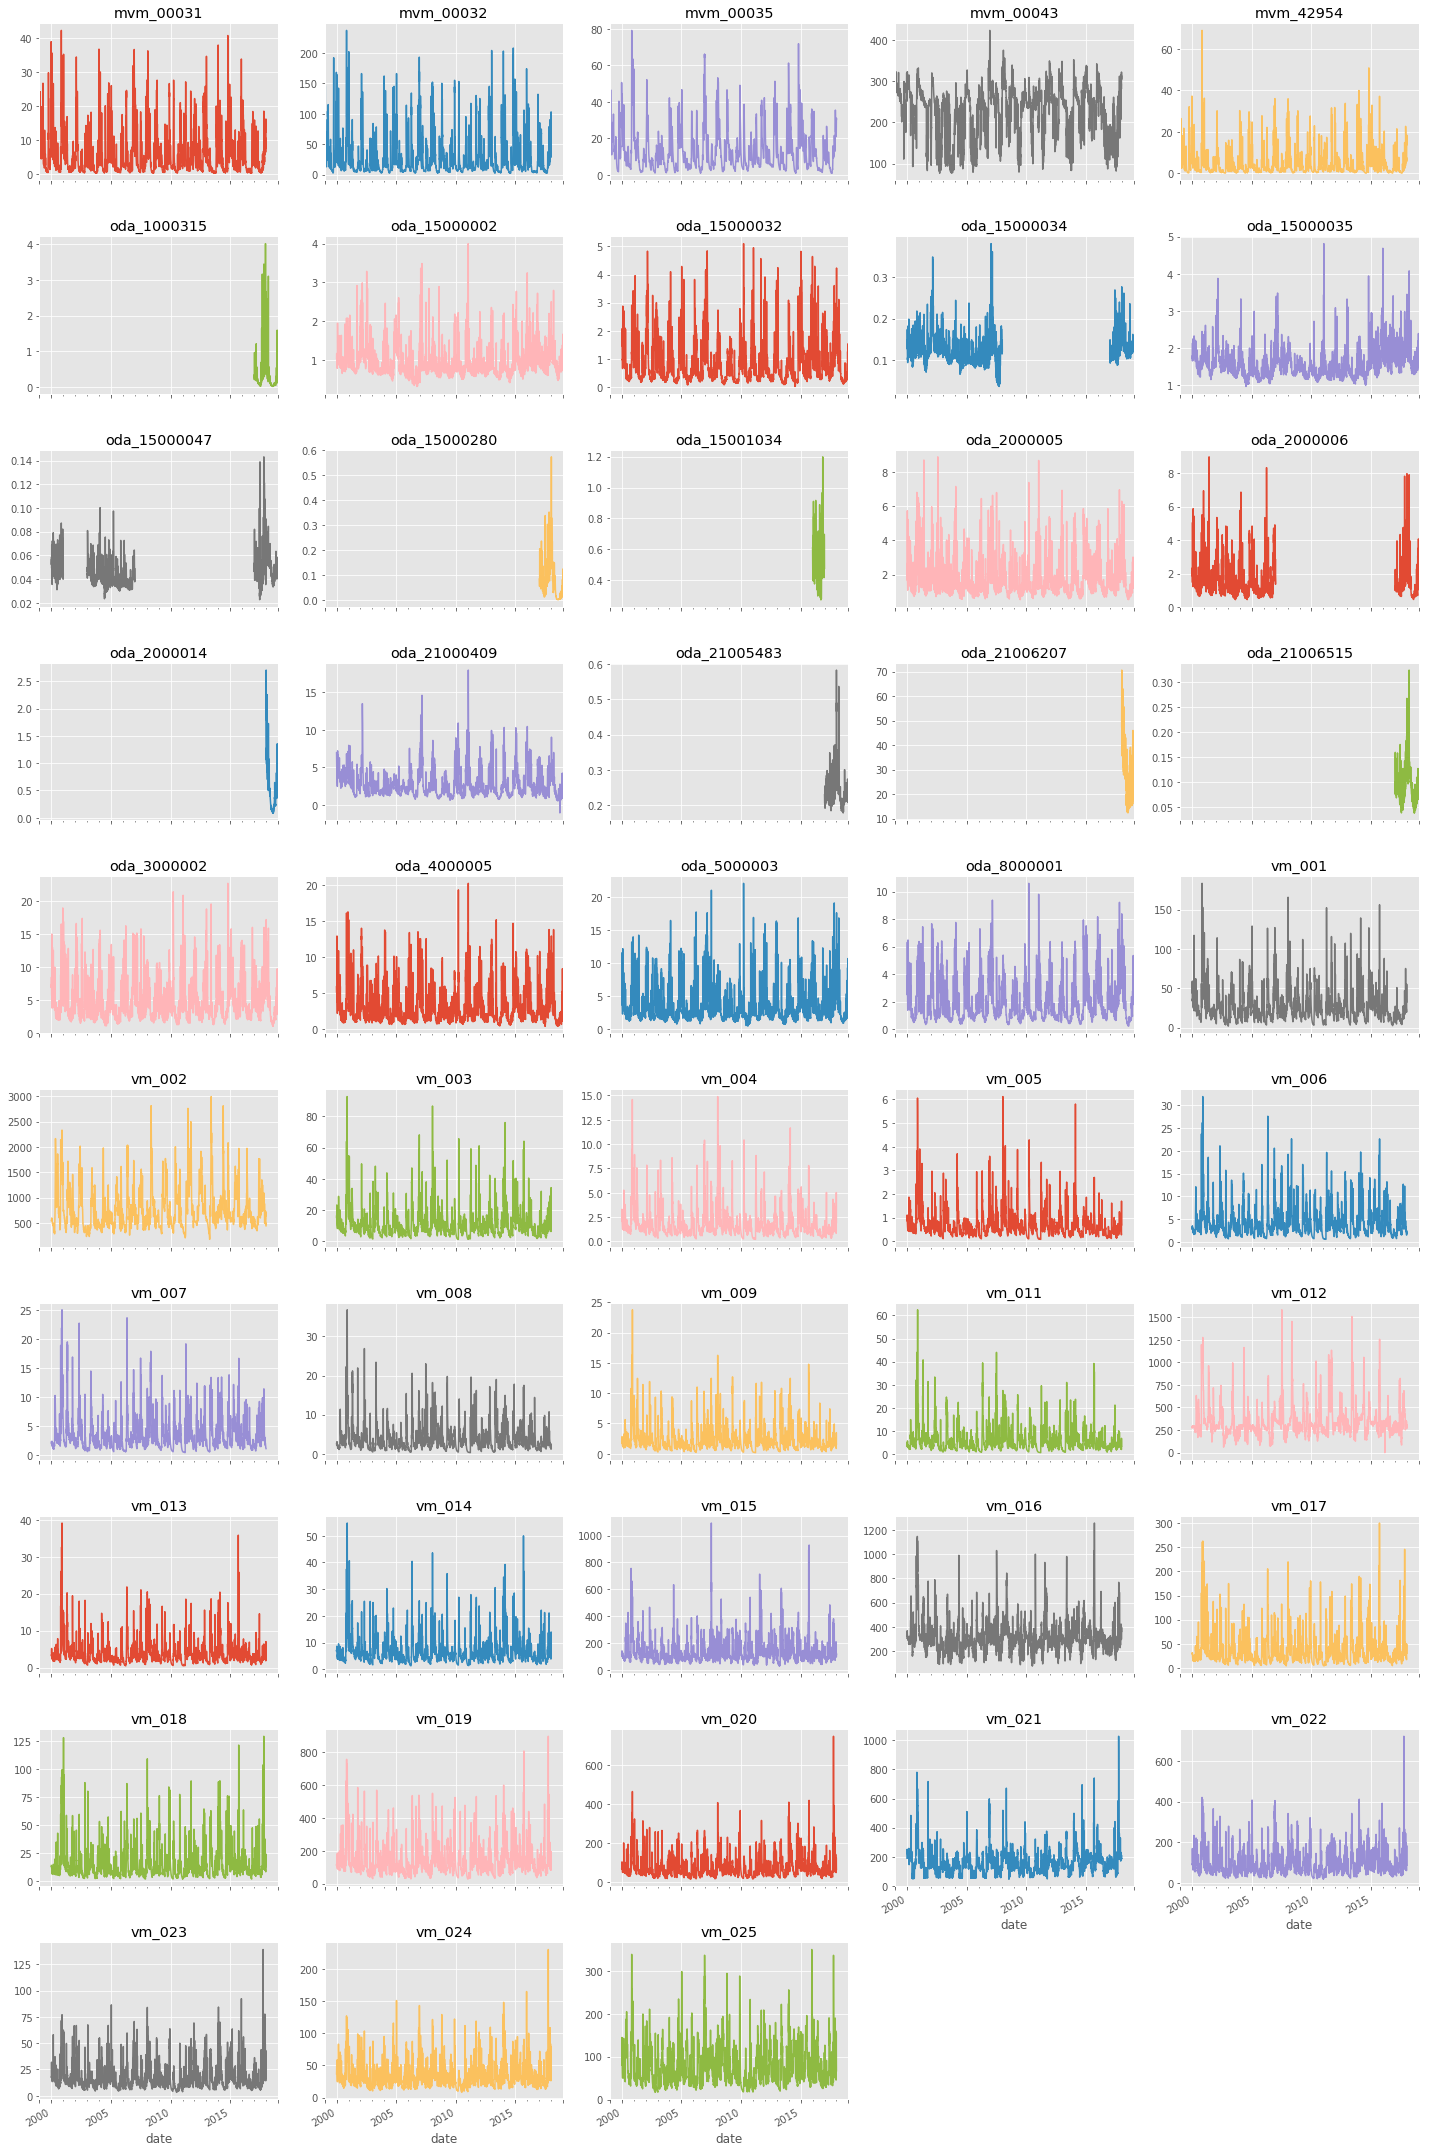

In [27]:
# Plot
q_df = q_df.set_index(['station_id', 'date'])
q_df = q_df.unstack('station_id').sort_index()
q_df.columns = q_df.columns.get_level_values(1)

q_df.plot(subplots=True, 
          layout=(10,5), 
          figsize=(20,30), 
          #marker='o',
          title=list(q_df.columns),
          legend=False)    
plt.tight_layout()

# Save png
png_path = r'../plots/raw_data/all_daily_flows.png'
plt.savefig(png_path, dpi=200)